# Warum ist die Banane krumm?

In [64]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2
import palettable
from astropy.cosmology import Planck15

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.profiles import MassProfileNFW, MassProfileSIE
from simulation.population_sim import SubhaloPopulation
from simulation import prior


## Grid

In [65]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

In [66]:
alt_grid = prior.get_grid()

In [67]:
for i in range(625):
    print (theta_grid[i], alt_grid[i])

[ 1.0e-03 -2.5e+00] [ 1.0e-03 -2.5e+00]
[ 0.00929167 -2.5       ] [ 0.00929167 -2.5       ]
[ 0.01758333 -2.5       ] [ 0.01758333 -2.5       ]
[ 0.025875 -2.5     ] [ 0.025875 -2.5     ]
[ 0.03416667 -2.5       ] [ 0.03416667 -2.5       ]
[ 0.04245833 -2.5       ] [ 0.04245833 -2.5       ]
[ 0.05075 -2.5    ] [ 0.05075 -2.5    ]
[ 0.05904167 -2.5       ] [ 0.05904167 -2.5       ]
[ 0.06733333 -2.5       ] [ 0.06733333 -2.5       ]
[ 0.075625 -2.5     ] [ 0.075625 -2.5     ]
[ 0.08391667 -2.5       ] [ 0.08391667 -2.5       ]
[ 0.09220833 -2.5       ] [ 0.09220833 -2.5       ]
[ 0.1005 -2.5   ] [ 0.1005 -2.5   ]
[ 0.10879167 -2.5       ] [ 0.10879167 -2.5       ]
[ 0.11708333 -2.5       ] [ 0.11708333 -2.5       ]
[ 0.125375 -2.5     ] [ 0.125375 -2.5     ]
[ 0.13366667 -2.5       ] [ 0.13366667 -2.5       ]
[ 0.14195833 -2.5       ] [ 0.14195833 -2.5       ]
[ 0.15025 -2.5    ] [ 0.15025 -2.5    ]
[ 0.15854167 -2.5       ] [ 0.15854167 -2.5       ]
[ 0.16683333 -2.5       ] [ 0.166833

[ 0.10879167 -1.54166667] [ 0.10879167 -1.54166667]
[ 0.11708333 -1.54166667] [ 0.11708333 -1.54166667]
[ 0.125375   -1.54166667] [ 0.125375   -1.54166667]
[ 0.13366667 -1.54166667] [ 0.13366667 -1.54166667]
[ 0.14195833 -1.54166667] [ 0.14195833 -1.54166667]
[ 0.15025    -1.54166667] [ 0.15025    -1.54166667]
[ 0.15854167 -1.54166667] [ 0.15854167 -1.54166667]
[ 0.16683333 -1.54166667] [ 0.16683333 -1.54166667]
[ 0.175125   -1.54166667] [ 0.175125   -1.54166667]
[ 0.18341667 -1.54166667] [ 0.18341667 -1.54166667]
[ 0.19170833 -1.54166667] [ 0.19170833 -1.54166667]
[ 0.2        -1.54166667] [ 0.2        -1.54166667]
[ 1.0e-03 -1.5e+00] [ 1.0e-03 -1.5e+00]
[ 0.00929167 -1.5       ] [ 0.00929167 -1.5       ]
[ 0.01758333 -1.5       ] [ 0.01758333 -1.5       ]
[ 0.025875 -1.5     ] [ 0.025875 -1.5     ]
[ 0.03416667 -1.5       ] [ 0.03416667 -1.5       ]
[ 0.04245833 -1.5       ] [ 0.04245833 -1.5       ]
[ 0.05075 -1.5    ] [ 0.05075 -1.5    ]
[ 0.05904167 -1.5       ] [ 0.05904167 -1.5 

## Load likelihood contours for comparison

In [59]:
filename = "alices_full"
setting = "full"
llr = np.mean(np.load("../data/results/llr_{}_grid.npy".format(filename)), axis=-1)
llr = -2. * llr
llr -= np.min(llr)

In [60]:
n_for_lines = [100, 20, 5, 1]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", "-.", ":"]
clabels = ["100", "20", "5", "1"]

## Calculate quantities

In [28]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [104]:
def calculate_summaries(f_sub, beta, n=20, n_theta_eval=10):
    if np.abs((beta + 2.)) < 1.e-3:
        beta = -2.001
    
    mhosts, total_msubs, avg_msubs, nsubs, m23s, deflections = [], [], [], [], [], []
    
    thetas_eval = np.vstack((np.random.normal(loc=0., scale=1., size=n_theta_eval),
                             np.random.normal(loc=0., scale=1., size=n_theta_eval))).T
    
    for i in range(n):
        m_min_calib=1e6 * M_s
        m_max_sub_div_M_hst_calib=0.01
        m_200_min_sub=1e7 * M_s
        m_200_max_sub_div_M_hst=0.01
        roi_size=2.
        M_200_sigma_v_scatter = True
        
        z_l = 2.0
        while z_l > 1.0:
            z_l = 10 ** np.random.normal(-0.25, 0.25)
        sigma_v = np.random.normal(225, 50)
        
        theta_s_e = 0.2
        z_s = 1.5
        mag_s = 23.0
        
        D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc
        D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
        D_ls = Planck15.angular_diameter_distance_z1z2(z1=z_l, z2=z_s).value * Mpc
        
        M_200_hst = M_200_sigma_v(sigma_v * Kmps, scatter=M_200_sigma_v_scatter)
        c_200_hst = MassProfileNFW.c_200_SCP(M_200_hst)
        r_s_hst, rho_s_hst = MassProfileNFW.get_r_s_rho_s_NFW(M_200_hst, c_200_hst)
        theta_E = MassProfileSIE.theta_E(sigma_v * Kmps, D_ls, D_s)
        
        f_sub_realiz = 2.0
        while f_sub_realiz > 1.0:
            ps = SubhaloPopulation(
                f_sub=f_sub,
                beta=beta,
                M_hst=M_200_hst,
                c_hst=c_200_hst,
                m_min=m_200_min_sub,
                m_max=m_200_max_sub_div_M_hst * M_200_hst,
                m_min_calib=m_min_calib,
                m_max_calib=m_max_sub_div_M_hst_calib * M_200_hst,
                theta_s=r_s_hst / D_l,
                theta_roi=roi_size * theta_E,
                theta_E=theta_E,
                params_eval=[],
                calculate_joint_score=False,
            )
            f_sub_realiz = ps.f_sub_realiz
            
        deflection = 0.
        for i_sub, (m, theta_x, theta_y) in enumerate(zip(ps.m_sample, ps.theta_x_sample, ps.theta_y_sample)):
            c = MassProfileNFW.c_200_SCP(m)
            r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
            sigma_cr = 1. / (4. * np.pi * GN) * D_s / (D_ls * D_l)
            
            for theta_x_eval, theta_y_eval in thetas_eval:
                r = ((theta_x - theta_x_eval)**2 + (theta_y-theta_y_eval)**2)**0.5 * D_l * asctorad
                x = r / r_s
                deflection += 4. * rho_s * r_s / sigma_cr * r_s * (np.log(x/2) + MassProfileNFW.F(x)) / x / n_theta_eval
            
        mhosts.append(ps.M_hst_roi/M_s)
        total_msubs.append(np.sum(ps.m_sample/M_s))
        avg_msubs.append(np.nanmean(ps.m_sample/M_s))
        nsubs.append(ps.n_sub_roi)
        m23s.append(np.sum((ps.m_sample/M_s)**(2./3.)))
        deflections.append(deflection)
    
    mean_total_msub = np.nanmean(total_msubs)
    mean_fsub = np.nanmean(np.asarray(total_msubs) / np.asarray(mhosts))
    mean_msub = np.nanmean(avg_msubs)
    mean_nsub = np.nanmean(nsubs)
    mean_m23 = np.nanmean(m23s)
    mean_deflection = np.nanmean(deflections)
    
    return mean_total_msub, mean_fsub, mean_msub, mean_nsub, mean_m23, mean_deflection

## Run

In [105]:
mean_total_msubs, mean_fsubs, mean_msubs, mean_nsubs, mean_m23s, mean_deflections = [], [], [], [], [], []

for i, theta in enumerate(theta_grid):
    if (i+1) % 10 == 0:
        print("{} / {}".format(i+1, 625))
    mean_total_msub, mean_fsub, mean_msub, mean_nsub, mean_m23, mean_deflection = calculate_summaries(theta[0], theta[1])
    mean_total_msubs.append(mean_total_msub)
    mean_fsubs.append(mean_fsub)
    mean_msubs.append(mean_msub)
    mean_nsubs.append(mean_nsub)
    mean_m23s.append(mean_m23)
    mean_deflections.append(mean_deflection)
    

/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice


10 / 625
20 / 625
30 / 625
40 / 625
50 / 625
60 / 625
70 / 625
80 / 625
90 / 625
100 / 625
110 / 625
120 / 625
130 / 625
140 / 625
150 / 625
160 / 625
170 / 625
180 / 625
190 / 625
200 / 625
210 / 625
220 / 625
230 / 625
240 / 625
250 / 625
260 / 625
270 / 625
280 / 625
290 / 625
300 / 625
310 / 625
320 / 625
330 / 625
340 / 625
350 / 625
360 / 625
370 / 625
380 / 625
390 / 625
400 / 625
410 / 625
420 / 625
430 / 625
440 / 625
450 / 625
460 / 625
470 / 625
480 / 625
490 / 625
500 / 625
510 / 625
520 / 625
530 / 625
540 / 625
550 / 625
560 / 625
570 / 625
580 / 625
590 / 625
600 / 625
610 / 625
620 / 625


## Plot

-2 LLR [ 0.03416667 -2.08333333] [ 0.2 -2.5]
Mean total subhalo mass [ 1.00000000e-03 -1.70833333e+00] [ 0.2   -1.625]
Mean subhalo mass fraction [ 1.00000000e-03 -1.58333333e+00] [ 0.18341667 -1.75      ]
Mean average subhalo mass [ 1.0e-03 -2.5e+00] [ 0.05904167 -1.5       ]
Mean number of subhalos [ 1.00000000e-03 -1.54166667e+00] [ 0.19170833 -2.25      ]
Mean $m^{2/3}$ [ 1.00000000e-03 -1.58333333e+00] [ 0.18341667 -2.125     ]
Mean deflection [ 1.00000000e-03 -1.58333333e+00] [ 0.16683333 -2.        ]


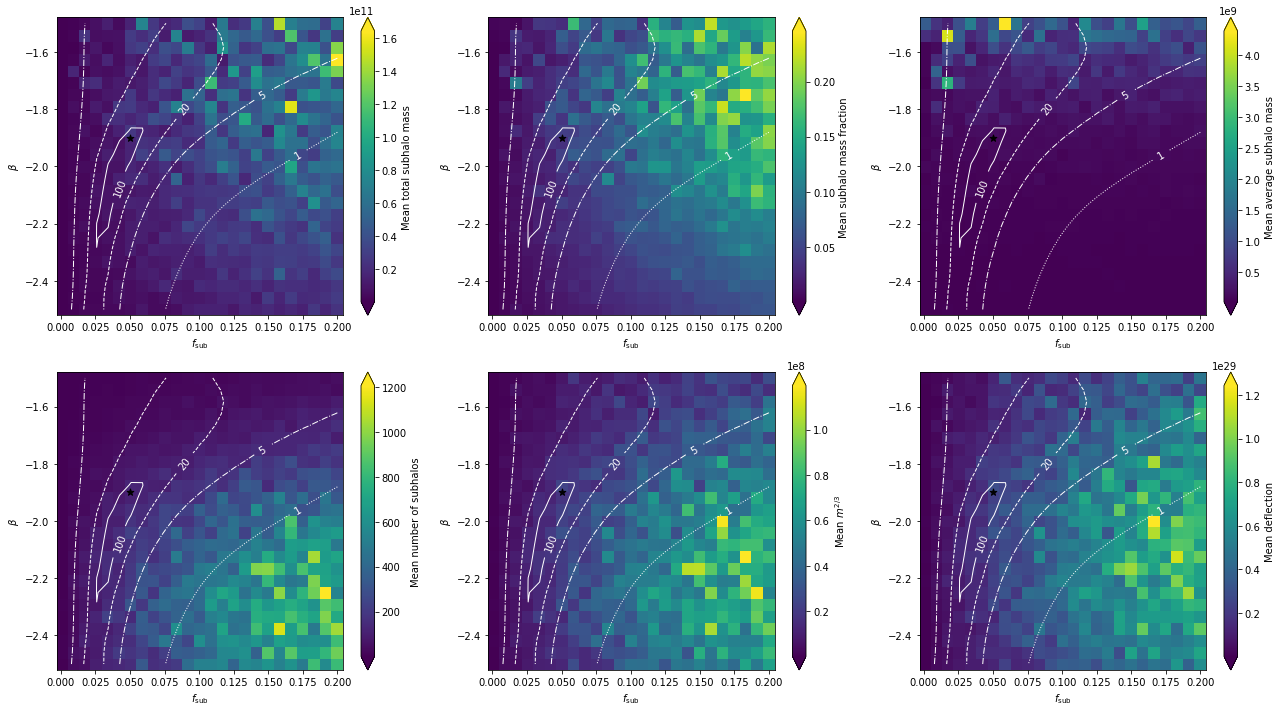

In [106]:
fig = plt.figure(figsize=(18,10))

print("-2 LLR", theta_grid[np.argmin(llr.flatten())], theta_grid[np.argmax(llr.flatten())])

for i, (data, label) in enumerate(zip(
    [mean_total_msubs, mean_fsubs, mean_msubs, mean_nsubs, mean_m23s, mean_deflections],
    ["Mean total subhalo mass", "Mean subhalo mass fraction", "Mean average subhalo mass", "Mean number of subhalos", "Mean $m^{2/3}$", "Mean deflection"]
)):
    ax = plt.subplot(2,3,i+1)
    data = np.asarray(data).reshape(25,25)
    
    print(label, theta_grid[np.argmin(data.flatten())], theta_grid[np.argmax(data.flatten())])
    
    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        data,
        #norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    cs = ax.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        llr.reshape((resolution, resolution)),
        thresholds,
        colors="white",
        linewidths=1.,
        linestyles=contour_ls,
    )
    
    plt.clabel(cs, fmt={thresholds[i] : clabels[i] for i in range(len(thresholds))},
          manual=[(0.04,-2.07), (0.09,-1.8), (0.14,-1.7), (0.17,-1.95)])
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(label)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/other/warum_ist_die_banane_krumm.pdf")
